<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - West Nile Virus Prediction (Kaggle) <br> [Part 3 of 4]

_Prepared by: Kho Guan Guo, Soh Sze Ron, Timothy Chan, 3 Apr 2023_

## Contents:
- [Feature Selection](#Feature-Selection)
- [Modelling](#Modelling)
- [Summary](#Summary)

**Part 3** consists of Feature Selection and Modelling.

### Data Dictionary

Data dictionary (selected features only).

|Features|Type|Description|
|:---|:---|:---|
|wnv_present|boolean|1 if West Nile Virus was present in these mosquitos when tested; 0 if it is not|
|wet_bulb|int|average wet bulb temperature in degrees fahrenheit|
|result_speed|float|vector sum of wind speed and direction in mph|
|minutes_between|int|daylight duration between sunrise and sunset in minutes|
|species_culex_xx|boolean|1 if it is that species of mosquitos; 0 if it is not|
|cluster_label_xx|boolean|1 if it is located in that cluster; 0 if it is not|

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# Import cleaned data
df_train = pd.read_csv('data/data_cleaned/train_clean.csv', parse_dates=True)
df_test = pd.read_csv('data/data_cleaned/test_clean.csv', parse_dates=True)
df_kaggle = pd.read_csv('data/test.csv')

---
## Feature Selection
---

Based on EDA done, the key features with strongest correlation or relationship with WNV cases are:
- daylight duration (to use "minutes_between")
- period of the year (to use "week_number")
- temperature (to use "wet_bulb" since correlation is higher)
- species (specifically culex_pipiens and culex_restuans)
- wind speed (to use "result_speed" since correlation is higher)
- location (represented by trap, address or coordinates)

We will stick to using these few features and use only one of each nature to reduce overfitting.

**Clustering**

Since there seems be certain locations which have more WNV cases, we will use clustering to create a location feature, then perform one-hot encode. This will simplify and keep the number of potential location features small.

For the train data, we use DBSCAN clustering to group clusters by coordinates in proximity to each other. Then we map this to the test data by address and street number.

In [3]:
# Perform DBSCAN clustering on train dataset with eps=0.01 and min_samples=5
dbscan = DBSCAN(eps=0.02, min_samples=20)
coords = df_train[['latitude', 'longitude']].values
labels = dbscan.fit_predict(coords)

# Add the cluster labels to the DataFrame
df_train['cluster_label'] = labels

# Print the number of clusters and their sizes
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
cluster_sizes = np.bincount(labels[labels!=-1])
print(f'Number of clusters: {n_clusters}')
print(f'Cluster sizes: {cluster_sizes}')

Number of clusters: 43
Cluster sizes: [ 542 1578  318 1037  136   43   28  205   79  189  181  147  139  102
  121  241  125  113  219  166   88  101   79  191  171   77   99  155
   77  266   41  126  100  194  209  119   92   69  154   96   84   54
   61]


In [4]:
# Create a dictionary mapping address_number_and_street to cluster label
train_dict = dict(zip(df_train['address_number_and_street'], df_train['cluster_label']))

# Apply the same mapping to the test dataset. -1 if mapping not available
test_labels = [train_dict.get(addr, -1) for addr in df_test['address_number_and_street']]
df_test['cluster_label'] = test_labels

df_test['cluster_label'].nunique()

44

We created 43 clusters for the train data. Test data will have one more cluster than train data, being those with no mapping available. This will be labelled "-1" and will be removed later.

We will explore the correlation between each cluster with wnv_present:

In [5]:
# Perform get dummies to see correlation of each cluster to wnv_present 
df_train_cluster = df_train[['wnv_present','num_mosquitos','cluster_label']]
df_train_cluster = pd.get_dummies(df_train_cluster, columns=['cluster_label'], drop_first=False)

In [6]:
# Spearman Correlation to 'wnv_present', 'num_mosquitos'; filter to exclude those with low correlation
corr_wnv_present = round(df_train_cluster.corr(method='spearman')['wnv_present'], 2)
filtered_corr_wnv_present = corr_wnv_present[(corr_wnv_present >= 0.03) | (corr_wnv_present <= -0.03)].sort_values(ascending=False)

corr_num_mosquitos = round(df_train_cluster.corr(method='spearman')['num_mosquitos'], 2)
filtered_num_mosquitos = corr_num_mosquitos[(corr_num_mosquitos >= 0.03) | (corr_num_mosquitos <= -0.03)].sort_values(ascending=False)

# Join into table
corr_comb = pd.concat([filtered_corr_wnv_present, filtered_num_mosquitos], axis=1)
corr_comb.replace(np.nan, 'low corr', inplace=True)
corr_comb

,wnv_present,num_mosquitos
wnv_present,1.0,0.26
num_mosquitos,0.26,1.0
cluster_label_38,0.08,0.15
cluster_label_1,0.05,0.03
cluster_label_5,0.03,low corr
cluster_label_19,0.03,0.05
cluster_label_40,0.03,0.04
cluster_label_3,-0.03,-0.09
cluster_label_9,-0.03,-0.06
cluster_label_33,-0.03,low corr


In [7]:
df_train[df_train['cluster_label'] == 38]['address_number_and_street'].value_counts()

1000  W OHARE AIRPORT, Chicago, IL    154
Name: address_number_and_street, dtype: int64

Cluster 38 with highest correlation only has 1 address: Ohare Airport. This is consistent with findings from EDA earlier that Ohare Airport is the location with most WNV cases.

In [8]:
df_train[df_train['cluster_label'] == 1]['address_number_and_street'].value_counts()

4100  N OAK PARK AVE, Chicago, IL        147
7000   W ARMITAGE AVENUE, Chicago, IL    143
7000  N MOSELL AVE, Chicago, IL          113
4600  N MILWAUKEE AVE, Chicago, IL       113
6100  W FULLERTON AVE, Chicago, IL        98
6100  N LEMONT AVE, Chicago, IL           97
5800  N PULASKI RD, Chicago, IL           90
6000  W MONTROSE DR, Chicago, IL          77
5100  N MONT CLARE AVE, Chicago, IL       75
3700  N KEDVALE AVE, Chicago, IL          72
3300  N RUTHERFORD AVE, Chicago, IL       69
3900  N SPRINGFIELD AVE, Chicago, IL      59
7200  N OKETO AVE, Chicago, IL            56
7100  N HARLEM AVE, Chicago, IL           46
6200  N MCCLELLAN AVE, Chicago, IL        32
7900  W FOSTER AVE, Chicago, IL           32
6500  N OAK PARK AVE, Chicago, IL         28
6400  W STRONG ST, Chicago, IL            28
6800  W BELDEN AVE, Chicago, IL           27
9100  W HIGGINS AVE, Chicago, IL          27
6000  N AVONDALE AVE, Chicago, IL         24
4900  W BALMORAL AVE, Chicago, IL         24
6200  N MA

Cluster 1 with second most correlation. Many of the address in Cluster 1 are in the top 20 infected locations (from earlier EDA) such as:
- Oak Park Ave
- Avondale Ave
- Roscoe St
- Strong St
- Harlem Ave

In [9]:
df_train[df_train['trap'] == 'T115']['cluster_label'].value_counts()

19    143
Name: cluster_label, dtype: int64

In [10]:
df_train[df_train['trap'] == 'T002']['cluster_label'].value_counts()

1    147
Name: cluster_label, dtype: int64

In EDA earlier, we idenfied that Trap T115 and T002 had highest number of WNV cases. We note here that they are within the top few clusters (cluster 19 and 1). This gives some assurance that the clustering is correct.

**One-hot encoding**

We perform one-hot encoding on species and cluster.

In [11]:
# Lower and replace spaces to prepare column names for species
df_train['species'] = df_train['species'].str.lower().str.replace(' ', '_')
df_test['species'] = df_test['species'].str.lower().str.replace(' ', '_')

In [12]:
# One-hot encode
df_train = pd.get_dummies(df_train, columns=['species', 'cluster_label'], drop_first=False) # drop in next step
df_test = pd.get_dummies(df_test, columns=['species', 'cluster_label'], drop_first=False) # drop in next step

**Drop unnecessary columns**

As mentioned, we will only keep a few selected features. For clusters, we will only keep those with most correlation to wnv_present.

In [13]:
# View columns
df_train.columns

Index(['date', 'trap', 'address_number_and_street', 'latitude', 'longitude',
       'num_mosquitos', 'wnv_present', 'station', 'tmax', 'tmin', 'tavg',
       'depart', 'dew_point', 'wet_bulb', 'sunrise', 'sunset', 'precip_total',
       'stn_pressure', 'sea_level', 'result_speed', 'result_dir', 'avg_speed',
       'relative_humidity', 'minutes_between', 'week_number', 'month', 'year',
       'coords', 'species_culex_erraticus', 'species_culex_pipiens',
       'species_culex_pipiens/restuans', 'species_culex_restuans',
       'species_culex_salinarius', 'species_culex_tarsalis',
       'species_culex_territans', 'cluster_label_-1', 'cluster_label_0',
       'cluster_label_1', 'cluster_label_2', 'cluster_label_3',
       'cluster_label_4', 'cluster_label_5', 'cluster_label_6',
       'cluster_label_7', 'cluster_label_8', 'cluster_label_9',
       'cluster_label_10', 'cluster_label_11', 'cluster_label_12',
       'cluster_label_13', 'cluster_label_14', 'cluster_label_15',
       'cluster_

In [14]:
# Keep only features wanted
columns_to_drop = [
       'date', 'trap', 'address_number_and_street', 'latitude', 'longitude',
       'station', 'tmax', 'tmin', 'tavg',
       'depart', 'dew_point', 'sunrise', 'sunset', 'precip_total',
       'stn_pressure', 'sea_level', 'result_dir', 'avg_speed',
       'relative_humidity', 'month', 'year', 'coords', 
       'species_culex_erraticus', 'species_culex_salinarius', 'species_culex_tarsalis', 'species_culex_territans', 
       'cluster_label_-1', 'cluster_label_0',
       'cluster_label_2', 
       'cluster_label_4', 'cluster_label_6',
       'cluster_label_7', 'cluster_label_8', 
       'cluster_label_10', 'cluster_label_11', 'cluster_label_12',
       'cluster_label_13', 'cluster_label_14', 'cluster_label_15',
       'cluster_label_16', 'cluster_label_17', 'cluster_label_18',
       'cluster_label_20', 'cluster_label_21',
       'cluster_label_22', 'cluster_label_23', 'cluster_label_24',
       'cluster_label_25', 'cluster_label_26', 'cluster_label_27',
       'cluster_label_28', 'cluster_label_29', 'cluster_label_30',
       'cluster_label_31', 'cluster_label_32', 
       'cluster_label_34', 'cluster_label_35', 'cluster_label_36',
       'cluster_label_37', 'cluster_label_39',
       'cluster_label_41', 'cluster_label_42'
]

df_train.drop(['num_mosquitos'], axis=1, inplace=True) # additional column to drop as this is not in test dataset
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(['id', 'species_unspecified_culex'], axis=1, inplace=True) # additional column to drop as this is not in test dataset
df_test.drop(columns_to_drop, axis=1, inplace=True)

In [15]:
# View train columns for modelling
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   wnv_present                     8475 non-null   int64  
 1   wet_bulb                        8475 non-null   int64  
 2   result_speed                    8475 non-null   float64
 3   minutes_between                 8475 non-null   int64  
 4   week_number                     8475 non-null   int64  
 5   species_culex_pipiens           8475 non-null   uint8  
 6   species_culex_pipiens/restuans  8475 non-null   uint8  
 7   species_culex_restuans          8475 non-null   uint8  
 8   cluster_label_1                 8475 non-null   uint8  
 9   cluster_label_3                 8475 non-null   uint8  
 10  cluster_label_5                 8475 non-null   uint8  
 11  cluster_label_9                 8475 non-null   uint8  
 12  cluster_label_19                84

In [16]:
# View test columns for modelling, and if consistent with train columns
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   wet_bulb                        116293 non-null  int64  
 1   result_speed                    116293 non-null  float64
 2   minutes_between                 116293 non-null  int64  
 3   week_number                     116293 non-null  int64  
 4   species_culex_pipiens           116293 non-null  uint8  
 5   species_culex_pipiens/restuans  116293 non-null  uint8  
 6   species_culex_restuans          116293 non-null  uint8  
 7   cluster_label_1                 116293 non-null  uint8  
 8   cluster_label_3                 116293 non-null  uint8  
 9   cluster_label_5                 116293 non-null  uint8  
 10  cluster_label_9                 116293 non-null  uint8  
 11  cluster_label_19                116293 non-null  uint8  
 12  cluster_label_33

We have 15 features and may reduce them further depending on the train/validation score and kaggle score.

---
## Modelling
---

**Evaluation Metrics** <br>
We will use area under the curve (AUC) to evaluate our models. A score of 0.5 will be a completely ineffective classifier while a score of 1 means a perfect classification. AUC captures the trade-off between the true positive rate (TPR) and false positive rate (FPR), or sensitivity/recall vs (1 - specificity)/precision. As the trade-off can be fine-tuned, it is more suitable than accuracy as a metrics. Furthermore since there is class imbalance in the dataset, it is more reliable than accuracy (in accuracy, we might just predict all as majority class to get a good score).

*Recall-Precision trade off:* <br>
Higher recall (TPR) reduces the produces more false negatives at the expense of more false positives. Precision has the opposite effect. False negative could mean that we under-spray areas with high number of WNV present, which leads to more infections than the city can handle. False positives could mean that we might over-spray areas with low number of WNV present, which means higher expenses of spraying. As the cost of false negatives and under-spraying is higher, recall should have a higher weight than precision. After optimizing AUC score, we will check if validation recall score is above 0.70 and adjust if necessary.

**Models used** <br>
We will use Logistic Regresssion, Multinomial Naive Bayes, Random Forest and XGBoost Models and see which perform better. We will also try reducing the number of features to see if this improves performance. Then we will finetune the selected model to try improve the Kaggle test score further.

In [17]:
# Train test split
y = df_train['wnv_present']
X = df_train.drop('wnv_present', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify =y)

In [18]:
# Function to find best hyperparameters for each model, and to compare each model result
def evaluate_models(models, X_train, X_val, y_train, y_val):
    results = ''
    best_est = []
    for model in models:
        classifier = model['classifier']
        params = model['params']
        
        # Create pipeline
        if model['name'] == 'LogisticRegression':
            pipeline = Pipeline([
                ('scale', StandardScaler()),
                ('sampling', SMOTE(random_state=42)),
                ('classifier', classifier)
            ])
        else:
            pipeline = Pipeline([
                ('scale', MinMaxScaler()),
                ('sampling', SMOTE(random_state=42)),
                ('classifier', classifier)
            ])
        
        # Gridsearch
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', n_jobs=-1) # 5 folds CV, use all processors
        grid_search.fit(X_train, y_train)

        # Get best estimator
        best_estimator = grid_search.best_estimator_

        # Score
        train_score = roc_auc_score(y_train, best_estimator.predict_proba(X_train)[:, 1])
        val_score = roc_auc_score(y_val, best_estimator.predict_proba(X_val)[:, 1])

        # Get confusion matrix values
        preds = best_estimator.predict(X_val)
        tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()

        # Score
        precision = precision_score(y_val, preds)
        recall = recall_score(y_val, preds)
        
        # Store best estimator
        best_est.append(best_estimator)      

        # Store results
        results += f"{model['name']}:\n"
        results += f"Best CV Params: {grid_search.best_params_}\n"
        results += f"Best CV AUC Score: {round(grid_search.best_score_, 3)}\n"
        results += f"Train AUC Score: {round(train_score, 3)}\n"
        results += f"Val AUC Score: {round(val_score, 3)} | TN: {tn} | FP: {fp} | FN: {fn} | TP: {tp}\n"
        results += f"Precision: {round(precision, 3)} | Recall: {round(recall, 3)} | Precision-Recall Ratio: {round(precision / recall, 3)}\n" 
        results += f"Overfitted (val minus train): {round(val_score - train_score, 3)}\n\n"
        
    return results, best_est

In [19]:
def selected_model_input(output, model_name, best_est, X_train, X_val, y_train, y_val):
    # Get best estimator for the selected model
    for estimator in best_est:
        if type(estimator.named_steps['classifier']) == model_name:
            selected_est = estimator

    # Fit the model and get predictions
    pipeline_1 = selected_est
    pipeline_1.fit(X_train, y_train)
    preds = pipeline_1.predict(X_val)

    # Calculate scores
    train_score = metrics.roc_auc_score(y_train, pipeline_1.predict_proba(X_train)[:, 1])
    val_score = metrics.roc_auc_score(y_val, pipeline_1.predict_proba(X_val)[:, 1])
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()

    # Get feature importance for models that have it
    feat_imp = None
    if model_name == LogisticRegression:
        # Get absolute values of coefficients
        lr_coef = pipeline_1.named_steps['classifier'].coef_[0]

        # Sort features by absolute coefficient values
        feat_imp = pd.DataFrame({'feature': X_train.columns, 'importance': lr_coef}).sort_values('importance', ascending=False)

    elif hasattr(selected_est.named_steps['classifier'], 'feature_importances_'):
        feat_imp = selected_est.named_steps['classifier'].feature_importances_
        # Convert feat_imp numpy array to pandas dataframe
        feat_imp = pd.DataFrame({'feature': X_train.columns, 'importance': feat_imp}).sort_values('importance', ascending=False)

    if output == 'score':
        print(f"Train Score: {round(train_score, 3)}")
        print(f"Val Score: {round(val_score, 3)} | TN: {tn} | FP: {fp} | FN: {fn} | TP: {tp}\n")

    elif output == 'confusion_matrix':
        # Plot confusion matrix
        cm = confusion_matrix(y_val, preds)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(cmap='Reds');
        
    elif output == 'roc_curve':
        # Plot ROC curve
        roc_display = RocCurveDisplay.from_estimator(pipeline_1, X_val, y_val)
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.legend()

    elif output == 'feature_importance':
        # Plot feature importance
        if feat_imp is None:
            print("Model does not have feature importance")
        else:
            plt.figure(figsize=(6, 6))
            sns.barplot(x='importance', y='feature', data=feat_imp)
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.show()

In [20]:
# Compare Kaggle test shape to train data
print(X_train.shape)
print(df_test.shape)

(6356, 15)
(116293, 15)


**Logistic Regression model**

In [21]:
# Define models with hyperparameters
classifier_lr_params = {
    'classifier__C': [0.1, 1, 10], # inverse of regularization strength; smaller values specify stronger regularization
    'classifier__max_iter': [100, 1_000]
}

lr_models = [
    {'name': 'LogisticRegression', 
         'classifier': LogisticRegression(), 
         'params': {**classifier_lr_params}}
    ]

In [22]:
lr_compare_results, lr_best_est = evaluate_models(lr_models, X_train, X_val, y_train, y_val)
print(lr_compare_results)

LogisticRegression:
Best CV Params: {'classifier__C': 10, 'classifier__max_iter': 100}
Best CV AUC Score: 0.786
Train AUC Score: 0.798
Val AUC Score: 0.791 | TN: 1360 | FP: 645 | FN: 25 | TP: 89
Precision: 0.121 | Recall: 0.781 | Precision-Recall Ratio: 0.155
Overfitted (val minus train): -0.007




In [23]:
# # Use best estimator to make predictions on test set
# pred_test_lr = lr_best_est[0].predict(df_test)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_lr = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test_lr})
# df_kaggle_lr.to_csv('data/data_submission/kaggle_lr01f.csv', index=False)

Kaggle private score for Logistic Regression: 0.65611 <br>
Model is heavily overfitted. To see if reduced features can improve test score. We will set this as our baseline score.

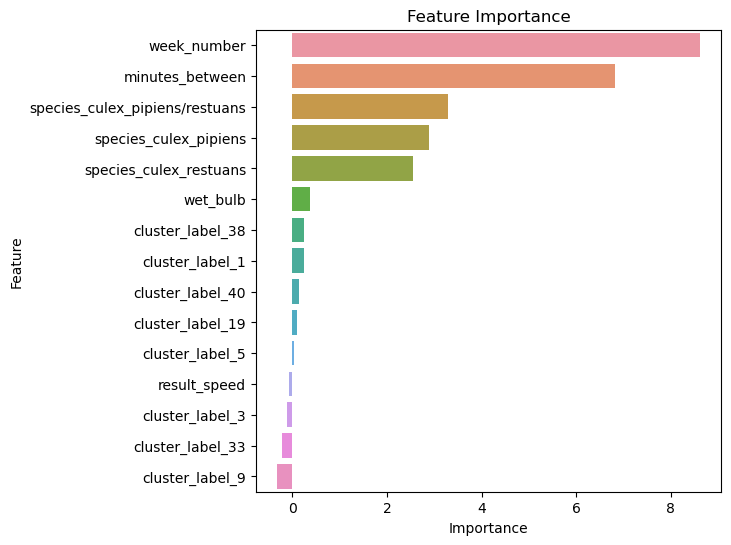

In [24]:
# Identify feature importance for selected model
selected_model_input('feature_importance', LogisticRegression, lr_best_est, X_train, X_val, y_train, y_val)

Species is the most important feature followed by temperature (wet_bulb) and then daylight duration (minutes_between). The direction of each coefficient is aligned to earlier findings in EDA. For example, longer daylight duration would lead to less cases of WNV present.

As expected, cluster 38 and 1 are the clusters with highest positive coefficients. Clusters 9 and 33 have highest negative coefficients.

**Logistic Regression model (Reduced features)**

In [25]:
columns_to_keep_02 = [
    'minutes_between', 'wet_bulb', 'week_number', 
    'species_culex_pipiens', 'species_culex_pipiens/restuans', 'species_culex_restuans', 'result_speed'
]

In [26]:
# Create new set of data for reduced features and perform train set split
y_02 = df_train['wnv_present']
X_02 = df_train[columns_to_keep_02].copy()
df_test_02 = df_test[columns_to_keep_02].copy()

X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_02, y_02, random_state = 42, stratify = y)

In [27]:
lr_compare_results_02, lr_best_est_02 = evaluate_models(lr_models, X_train_02, X_val_02, y_train_02, y_val_02)
print(lr_compare_results_02)

LogisticRegression:
Best CV Params: {'classifier__C': 1, 'classifier__max_iter': 100}
Best CV AUC Score: 0.76
Train AUC Score: 0.768
Val AUC Score: 0.748 | TN: 1217 | FP: 788 | FN: 26 | TP: 88
Precision: 0.1 | Recall: 0.772 | Precision-Recall Ratio: 0.13
Overfitted (val minus train): -0.02




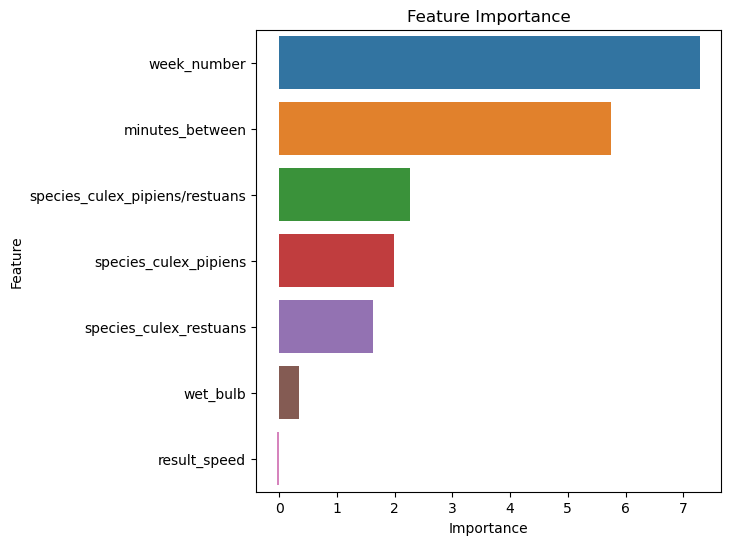

In [28]:
# Identify feature importance for Logistic Regression model
selected_model_input('feature_importance', LogisticRegression, lr_best_est_02, X_train_02, X_val_02, y_train_02, y_val_02)

In [29]:
# # Use best estimator to make predictions on test set
# pred_test_lr02 = lr_best_est_02[0].predict(df_test_02)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_lr02 = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test_lr02})
# df_kaggle_lr02.to_csv('data/data_submission/kaggle_lr02f.csv', index=False)

Kaggle private score for Logistic Regression (reduced features): 0.58218 <br>
Model does considerably worse with reduced features. Since there is too wide a gap to improve Logistic Regression model, we will not finetune parameters or features further.

**Multinomial Naive Bayes Model**

In [30]:
# Define models with hyperparameters
classifier_nb_params = {
    'classifier__alpha': [0.1, 0.5, 1], # smoothing parameter; larger values means more smoothing
}

nb_models = [
    {'name': 'MultinomialNB', 
         'classifier': MultinomialNB(), 
         'params': {**classifier_nb_params}}   
    ]

In [31]:
nb_compare_results, nb_best_est = evaluate_models(nb_models, X_train, X_val, y_train, y_val)
print(nb_compare_results)

MultinomialNB:
Best CV Params: {'classifier__alpha': 1}
Best CV AUC Score: 0.705
Train AUC Score: 0.716
Val AUC Score: 0.708 | TN: 1130 | FP: 875 | FN: 30 | TP: 84
Precision: 0.088 | Recall: 0.737 | Precision-Recall Ratio: 0.119
Overfitted (val minus train): -0.007




As Multinomial Naive Bayes val score (0.713) does considerably worse than Logistic Regression (0.765), we will not check the Kaggle score or finetune this model further.

**Random Forest Model**

In [32]:
# Define models with hyperparameters
classifier_rf_params = {
    'classifier__n_estimators': [100, 150, 200], # number of trees in the forest
    'classifier__max_depth': [7, 9, 11] # maximum depth of the tree
}

rf_models = [
    {'name': 'RandomForest', 
         'classifier': RandomForestClassifier(random_state=42), 
         'params': {**classifier_rf_params}},
]

In [33]:
# Evaluate random forest model
rf_compare_results, rf_best_est = evaluate_models(rf_models, X_train, X_val, y_train, y_val)
print(rf_compare_results)

RandomForest:
Best CV Params: {'classifier__max_depth': 11, 'classifier__n_estimators': 200}
Best CV AUC Score: 0.82
Train AUC Score: 0.885
Val AUC Score: 0.838 | TN: 1632 | FP: 373 | FN: 34 | TP: 80
Precision: 0.177 | Recall: 0.702 | Precision-Recall Ratio: 0.252
Overfitted (val minus train): -0.047




In [34]:
# # Use best estimator to make predictions on test set
# pred_test = rf_best_est[0].predict(df_test)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_rf = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test})
# df_kaggle_rf.to_csv('data/data_submission/kaggle_rf01f.csv', index=False)

Kaggle private score for Random Forest: 0.60943 <br>
Model is heavily overfitted. To see if reduced features can improve test score.

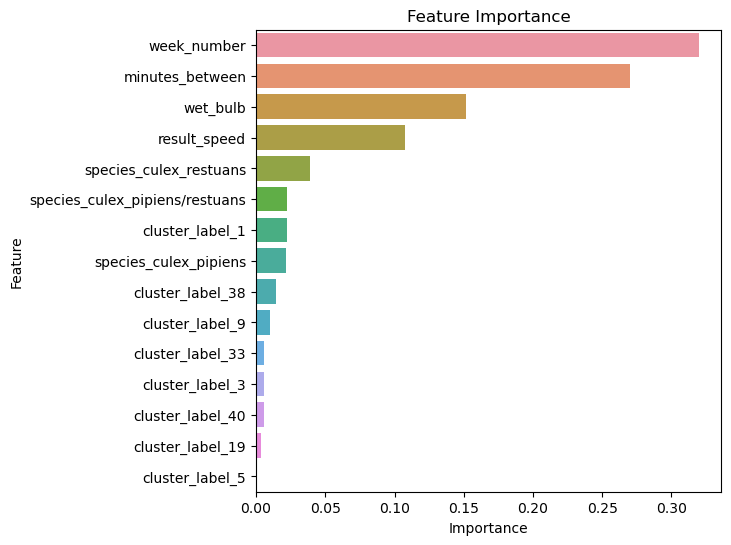

In [35]:
# Identify feature importance for Random Forest Model
selected_model_input('feature_importance', RandomForestClassifier, rf_best_est, X_train, X_val, y_train, y_val)

Feature importance shown for Random Forest are absolute values.

Since clusters are least important, will remove these features.

In [36]:
# Evaluate random forest model
rf_compare_results_02, rf_best_est_02 = evaluate_models(rf_models, X_train_02, X_val_02, y_train_02, y_val_02)
print(rf_compare_results_02)

RandomForest:
Best CV Params: {'classifier__max_depth': 11, 'classifier__n_estimators': 100}
Best CV AUC Score: 0.821
Train AUC Score: 0.867
Val AUC Score: 0.822 | TN: 1573 | FP: 432 | FN: 35 | TP: 79
Precision: 0.155 | Recall: 0.693 | Precision-Recall Ratio: 0.223
Overfitted (val minus train): -0.045




In [37]:
# # Use best estimator to make predictions on test set
# pred_test_02 = rf_best_est_02[0].predict(df_test_02)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_rf_02 = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test_02})
# df_kaggle_rf_02.to_csv('data/data_submission/kaggle_rf02f.csv', index=False)

Kaggle private score for Random Forest: 0.68027 <br>
Reduced features improved the test score significantly. To finetune and explore if this model is chosen.

**XGBoost Model**

In [38]:
# Define models with hyperparameters
classifier_xgb_params = {
    "classifier__learning_rate": [0.10, 0.12, 0.14],
    "classifier__max_depth": [3, 4],
    "classifier__n_estimators": [100, 125, 150],
}


xgb_models = [
    {'name': 'XGBoost', 
         'classifier': XGBClassifier(random_state=42), 
         'params': {**classifier_xgb_params}}
]

In [39]:
# Original features
xgb_compare_results, xgb_best_est = evaluate_models(xgb_models, X_train, X_val, y_train, y_val)
print(xgb_compare_results)

XGBoost:
Best CV Params: {'classifier__learning_rate': 0.14, 'classifier__max_depth': 4, 'classifier__n_estimators': 150}
Best CV AUC Score: 0.832
Train AUC Score: 0.882
Val AUC Score: 0.844 | TN: 1783 | FP: 222 | FN: 52 | TP: 62
Precision: 0.218 | Recall: 0.544 | Precision-Recall Ratio: 0.401
Overfitted (val minus train): -0.038




In [40]:
# # Use best estimator to make predictions on test set
# pred_test = xgb_best_est[0].predict(df_test)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_xgb = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test})
# df_kaggle_xgb.to_csv('data/data_submission/kaggle_xgb01f.csv', index=False)

In [41]:
# Reduced features
xgb_compare_results_02, xgb_best_est_02 = evaluate_models(xgb_models, X_train_02, X_val_02, y_train_02, y_val_02)
print(xgb_compare_results_02)

XGBoost:
Best CV Params: {'classifier__learning_rate': 0.14, 'classifier__max_depth': 3, 'classifier__n_estimators': 125}
Best CV AUC Score: 0.825
Train AUC Score: 0.855
Val AUC Score: 0.832 | TN: 1561 | FP: 444 | FN: 35 | TP: 79
Precision: 0.151 | Recall: 0.693 | Precision-Recall Ratio: 0.218
Overfitted (val minus train): -0.023




In [42]:
# # Use best estimator to make predictions on test set
# pred_test_02 = xgb_best_est_02[0].predict(df_test_02)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_xgb_02 = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test_02})
# df_kaggle_xgb_02.to_csv('data/data_submission/kaggle_xgb02f.csv', index=False)

Kaggle private score for XGBoost: 0.57886 <br>
Kaggle private score for XGBoost (reduced features): 0.60019 <br>
Reduced features improved the test score significantly. However as Random Forest performed the best by a substantial amount, we will focus on improving the score for random forest.

**Finetune selected model (Random Forest)**

For best kaggle score, val score is 0.822 and overfitting between train and val score is -0.04. From earlier tries, reducing the overfitting has the biggest impact to the Kaggle score. We will try to reduce overfitting to less than 0.04 while keeping val score above 0.80.

In [43]:
# Define models with hyperparameters
smote_params = {
    'sampling__sampling_strategy': ['minority', 'not majority'],
    'sampling__k_neighbors': [3, 5, 7],
}

classifier_rf_params = {
    'classifier__n_estimators': [80, 100, 120], # number of trees in the forest
    'classifier__max_depth': [6, 7, 8], # maximum depth of the tree
    'classifier__min_samples_split': [10, 11, 12, 13], # minimum samples required to split an internal node. Higher number can reduce overfitting
    'classifier__min_samples_leaf': [2, 4, 6] # minimum samples required at a leaf node. Higher number can reduce overfitting
}

rf_models_finetune = [
    {'name': 'RandomForest', 
         'classifier': RandomForestClassifier(random_state=42), 
         'params': {**classifier_rf_params, **smote_params}},
]

In [44]:
# Evaluate random forest model
rf_compare_results_finetune, rf_best_est_finetune = evaluate_models(rf_models_finetune, X_train_02, X_val_02, y_train_02, y_val_02)
print(rf_compare_results_finetune)

RandomForest:
Best CV Params: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 13, 'classifier__n_estimators': 100, 'sampling__k_neighbors': 3, 'sampling__sampling_strategy': 'minority'}
Best CV AUC Score: 0.823
Train AUC Score: 0.859
Val AUC Score: 0.822 | TN: 1499 | FP: 506 | FN: 29 | TP: 85
Precision: 0.144 | Recall: 0.746 | Precision-Recall Ratio: 0.193
Overfitted (val minus train): -0.037




In [45]:
# # Use best estimator to make predictions on test set
# pred_test_finetune = rf_best_est_finetune[0].predict(df_test_02)

# # Convert predictions to dataframe and save to CSV
# df_kaggle_rf_finetune = pd.DataFrame({'Id' : df_kaggle['Id'], 'WnvPresent' : pred_test_finetune})
# df_kaggle_rf_finetune.to_csv('data/data_submission/kaggle_rf03f.csv', index=False)

Kaggle private score for Finetuned Random Forest: **0.70135 (final score)**.

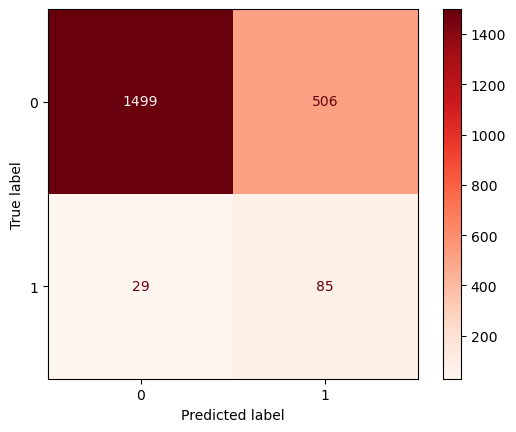

In [46]:
# Plot confusion matrix for selected model
selected_model_input('confusion_matrix', RandomForestClassifier, rf_best_est_finetune, X_train_02, X_val_02, y_train_02, y_val_02)

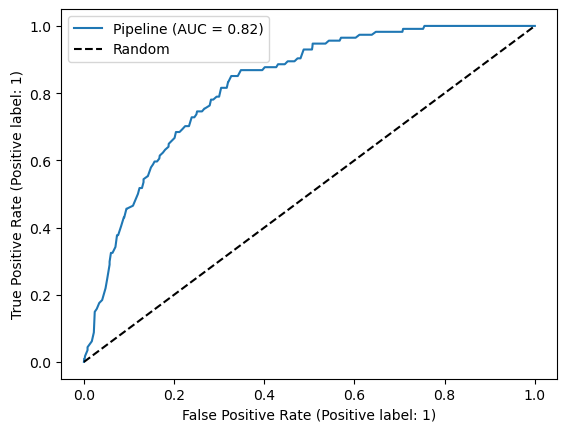

In [47]:
# Plot ROC curve for selected model
selected_model_input('roc_curve', RandomForestClassifier, rf_best_est_finetune, X_train_02, X_val_02, y_train_02, y_val_02)

The model heavily emphasises recall over precision.
- from the confusion matrix, there are 560 false positives and 26 false negatives
- precision to recall ratio is 0.176 (recall weighed 5.7 times of precision)
- recall score is reasonable at 0.772

This is acceptable because we prefer to have more cases of over-spraying than under-spraying.

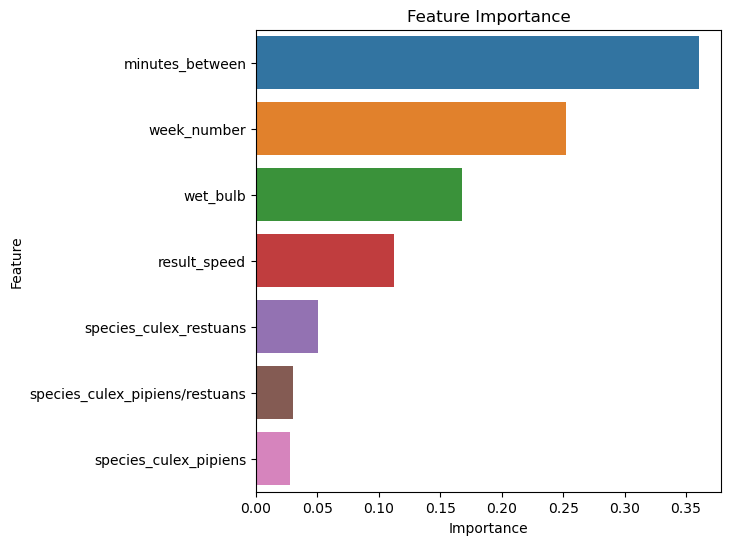

In [48]:
# Identify feature importance for selected model
selected_model_input('feature_importance', RandomForestClassifier, rf_best_est_finetune, X_train_02, X_val_02, y_train_02, y_val_02)

For the selected random forest model, daylight duration is the most important factor by far, followed by week number, temperature and then wind speed.

---
## Summary
---

**Summary of results**

|Model|Classifier|AUC (CV)|AUC (Train)|AUC (Val)|AUC (Kaggle)|Recall (Val)|Pros|Cons|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|1|Logistic Regression|0.786|0.798|0.791|0.656|0.781|fast; easy to interpret|may not capture complex/non-lineaer relationship|
|2|Logistic Regression (less features)|0.760|0.768|0.748|0.582|0.772|fast; easy to interpret|may not capture complex/non-lineaer relationship|
|3|Multinomial Naive Bayes|0.705|0.716|0.708|N/A|0.737|fast and simple|may not capture complex/non-linear relationship|
|5|Random Forest|0.820|0.885|0.838|0.609|0.702|robust to noise; can capture complex/non-linear relationship|slower|
|6|Random Forest (less features)|0.821|0.867|0.822|0.680|0.693|robust to noise; can capture complex/non-linear relationship|slower|
|7|XGBoost|0.832|0.882|0.844|0.579|0.544|robust to noise; can capture complex/non-linear relationship|slower|
|8|XGBoost|0.825|0.855|0.832|0.600|0.693|robust to noise; can capture complex/non-linear relationship|slower|
|9|**Random Forest (less Features) finetuned**|0.823|0.859|0.822|**0.701**|0.746|robust to noise; can capture complex/non-linear relationship|slower|

Random Forest had the least amount of overfitting when tested using the Kaggle dataset. It also has a reasonable recall score of 0.746. 

Location was dropped as a feature because it caused overfitting for the selected Random Forest model. This could be because big cluster areas vary in location from year to year, as explored in the EDA earlier.
<br>
<br>
<br>
**Hindsight** <br>
It was quite challenging to get a good score. This could be because of how the Kaggle datasets were designed: train (2007, 2009, 2011, 2013) and test data (2008, 2010, 2012, 2014) were split in alternate years. We have to use data from some years to predict results for other years. While not exactly a time-series problem, this makes it more unpredictable as there could be other factors such as time element or year specific elements which could not be identified and trained (without looking at the test data).

Even though there is very little overfitting when doing train-test split and validating, it was heavily overfitted on the test data. In hindsight. we could further explore techniques in designing validation to overcome this issue. For example, we could do train-test split by years, and perform training and validation on different years. This might make the model more robust to year sensitive elements.